![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# **Taller No. 9 - ISIS4825**

## **Regresión Logística para Clasificación Binaria y Análisis de Componentes Principales**

## **Objetivos**
## **Problema**

## **Notebook Configuration**

In [ ]:
!shred -u setup_colab.py
!wget "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_workshop_9()

## **Importando las librerías necesarias para el laboratorio**

In [2]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, ShuffleSplit, 
                                     cross_val_score, GridSearchCV)
from sklearn.metrics import (precision_score, recall_score, confusion_matrix, 
                             accuracy_score, f1_score, roc_curve, 
                             precision_recall_curve)
from sklearn.utils import resample

from utils import general as gen

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

## **Carga de Datos**

In [3]:
train_dir = gen.create_and_verify("data", "sign_mnist_train.csv")
test_dir = gen.create_and_verify("data", "sign_mnist_test.csv")

In [4]:
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [5]:
full_X_train, full_y_train = train_data.drop(columns=["label"]), train_data["label"]
X_test, y_test = test_data.drop(columns=["label"]), test_data["label"]

In [6]:
if (full_y_train == 9).sum() == 0 or (y_test == 9).sum() == 0:
    full_y_train = full_y_train.apply(lambda x: x - 1 if x > 8 else x)
    y_test = y_test.apply(lambda x: x - 1 if x > 8 else x)

In [7]:
full_X_train.shape, full_y_train.shape

((27455, 784), (27455,))

In [ ]:
X_test.shape, y_test.shape

((7172, 784), (7172,))

## **Visualización y Análisis Exploratorio**

![image](https://docs.google.com/uc?export=download&id=17e0VoyKW_0HgmItDWqGiyB1Bl6C-e8G8)

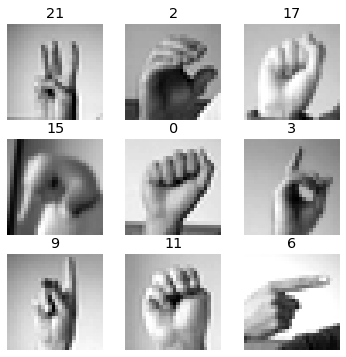

In [ ]:
random_sample = full_X_train.sample(9)
gen.visualize_subplot(
    random_sample.values.reshape(-1, 28, 28),
    full_y_train[random_sample.index].values, (3, 3), (6, 6)
)

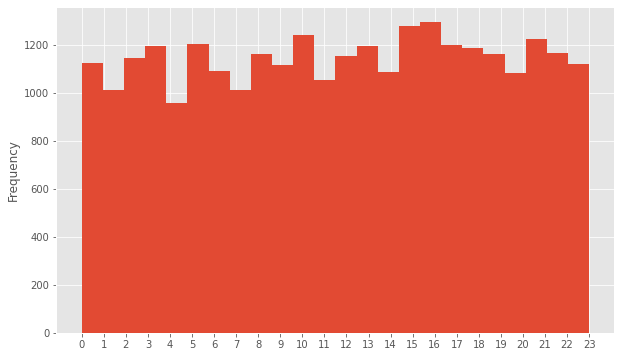

In [ ]:
plt.figure(figsize=(10, 6))
ax = full_y_train.plot(kind="hist", bins=24)
ax.set_xticks(range(24))
plt.show()

In [ ]:
full_y_train.value_counts().sort_index()

0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
9     1114
10    1241
11    1055
12    1151
13    1196
14    1088
15    1279
16    1294
17    1199
18    1186
19    1161
20    1082
21    1225
22    1164
23    1118
Name: label, dtype: int64

## **Preparación de los Datos**

In [ ]:
random_sample = full_X_train.sample(1)
sample_target = full_y_train[random_sample.index].values

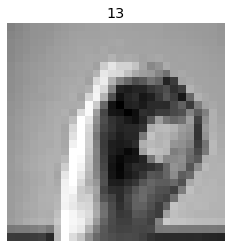

In [ ]:
gen.imshow(random_sample.values.reshape(28, 28), color=False, 
           title=sample_target[0])

In [ ]:
full_y_train_a = (full_y_train == 16)
y_test_a = (y_test == 16)

### **Train Set, Validation Set, Test Set**

In [ ]:
X_train, X_val, y_train_a, y_val_a = train_test_split(full_X_train, 
                                                      full_y_train_a, 
                                                      test_size=0.2, 
                                                      random_state=1234)

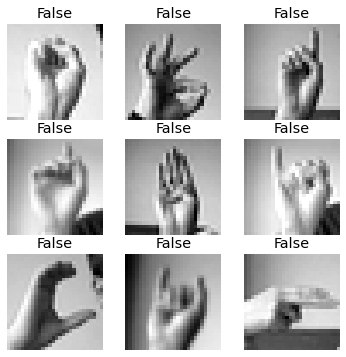

In [ ]:
random_sample = X_train.sample(9)
gen.visualize_subplot(
    random_sample.values.reshape(-1, 28, 28),
    y_train_a[random_sample.index].values, (3, 3), (6, 6)
)

### **Desbalanceo de Clases**
$$\text{freq}_p = \frac{\text{Número de instancias positivas}}{\text{Total de instancias}}$$

$$\text{freq}_n = \frac{\text{Número de instancias negativas}}{\text{Total de instancias}}$$

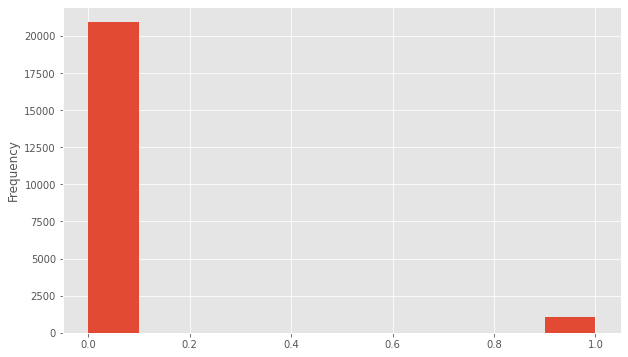

In [ ]:
plt.figure(figsize=(10, 6))
y_train_a.astype("int").plot(kind="hist")
plt.show()

In [ ]:
def cat_frequencies(labels):
    freq_p = labels.mean()
    freq_n = 1 - freq_p
    return freq_p, freq_n

In [ ]:
f_p, f_n = cat_frequencies(y_train_a)

In [ ]:
f_p, f_n

(0.04739573848115097, 0.952604261518849)

In [ ]:
total = pd.concat([X_train, y_train_a], axis=1)

In [ ]:
neg_class = total.query("label==0")
pos_class = total.query("label==1")

In [ ]:
neg_class_downsampled = resample(neg_class, replace=False,
                                 n_samples=len(pos_class), 
                                 random_state=1234)

In [ ]:
balanced_data = pd.concat([neg_class_downsampled, pos_class])

In [ ]:
y_train_a = balanced_data["label"]
X_train = balanced_data.drop("label", axis=1)

In [ ]:
f_p, f_n = cat_frequencies(y_train_a)

In [ ]:
f_p, f_n

(0.5, 0.5)

## **Modelamiento**

In [ ]:
log_reg = LogisticRegression(n_jobs=-1)

In [ ]:
log_reg.fit(X_train, y_train_a)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## **Predicción**

In [ ]:
random_sample = X_test.sample(9)
y_pred = log_reg.predict(random_sample)

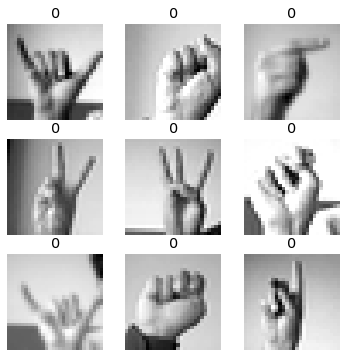

In [ ]:
gen.visualize_subplot(
    random_sample.values.reshape(-1, 28, 28),
    y_pred.astype("int"), (3, 3), (6, 6)
)

## **Validación**

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test_a, y_pred)

In [ ]:
pd.DataFrame(conf_matrix)

,0,1
0,6826,202
1,107,37


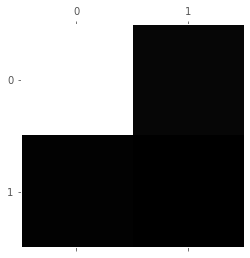

In [ ]:
plt.matshow(conf_matrix, cmap="gray")
plt.grid(0)
plt.show()

In [ ]:
norm_conf_mat = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_conf_mat, 0)

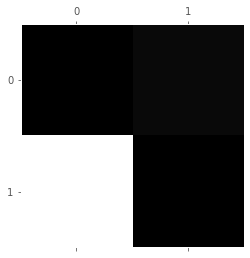

In [ ]:
plt.matshow(norm_conf_mat, cmap="gray")
plt.grid(0)
plt.show()

In [ ]:
accuracy_score(y_test_a, y_pred)

0.9569157836029002

In [ ]:
recall_score(y_test_a, y_pred)

0.2569444444444444

In [ ]:
precision_score(y_test_a, y_pred)

0.15481171548117154

In [ ]:
cross_val_score(log_reg, full_X_train, full_y_train_a, cv=4, scoring="recall")

array([0.93498452, 0.96604938, 0.9382716 , 0.95975232])

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
recall_score(y_test_a, y_pred)

0.2569444444444444